In [1]:
# imports
import torch
import h5py as h5
from torch.nn import init
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from run import lca_iterates
from utils.build_dataset import init_dataset, init_sf_dataset, MEADataset, load_symea
from torch.utils.data import DataLoader
from model.Lca import LCA
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from plots.plot import lca_sorting, lca_output, lca_atoms, lca_lasso
from utils.metrics import compute_accuracy
from utils.tools import get_subdataset, presence_factor
import MEAutility as mu

np.random.seed(0xC0DE)
torch.manual_seed(0xC0DE)


def init_lca(infos, natoms, tau, threshold, iters, q, beta, lr, n_model="V1"):
    # initialize dictionary
    D = init.xavier_normal_(
        torch.zeros(
            (infos["input_size"], natoms),
            requires_grad=False,
            dtype=torch.float32,
            device="cpu",
        ),
        gain=1.44,
    )

    lca = LCA(
        input_size=infos["input_size"],
        tau=tau,
        threshold=threshold,
        natoms=natoms,
        iters=iters,
        lr=lr,
        beta=beta,
        n_model=n_model,
        q=q,
        D=D,
    )

    return lca


def init_dataloader(dataset, batch_size, normalize=True):
    train_loader = DataLoader(
        MEADataset(
            dataset["train"]["wv"], dataset["train"]["raster"], normalize=normalize
        ),
        batch_size=batch_size,
        num_workers=4,
        pin_memory=False,
    )
    eval_loader = DataLoader(
        MEADataset(
            dataset["eval"]["wv"], dataset["eval"]["raster"], normalize=normalize
        ),
        batch_size=batch_size,
        num_workers=4,
        pin_memory=False,
    )
    return train_loader, eval_loader


def convert_to_fp(matrix, mantissa_bits):
    if np.linalg.norm(matrix) == 0:
        return matrix.astype(int), 0
    else:
        exp = np.ceil(np.log2(np.max(np.abs(matrix))))
        exp -= mantissa_bits - 1  # reduce by 1 for sign bit
        mat_fp_man = (matrix // 2**exp).astype(int)
        return mat_fp_man.astype(int), exp.astype(int)

Initialization

In [2]:
# Hyperparameters
fs = 2e4
batch_size = 256
iters = 200
lr = 0.1
natoms = 200
beta = 0  # add regularization factor

# neuron model parameters
n_model = "TDQ"
tau = 1e-3
threshold = 0.05
q = 2**32 - 1

# dataset parameters
dataset_path = "data/SYMEA_n12_nsd8_Npxl24_presmin4500.h5"
mea_probe = mu.return_mea("Neuropixels-24")

In [3]:
# get symea dataset
infos, dataset = init_dataset(dataset_path, eval_size=0.2, test_size=0.1)
# reduce dataset
infos, dataset, templates = get_subdataset(
    infos,
    dataset,
    nneurons=12,
    num_wv_per_neuron=1000,
    remove_similar_templates=True,
    th_sim=0.7,
)
# neuronID, count = np.unique(dataset["train"]["raster"][:, 1], return_counts=True)
# print("train set")
# print(f"Neuron IDs : {neuronID} \n SNR: {infos['snr']}\n Number of waveforms: {count}")
# print("eval set")
# neuronID, count = np.unique(dataset["eval"]["raster"][:, 1], return_counts=True)
# print(f"Neuron IDs : {neuronID} \n SNR: {infos['snr']}\n Number of waveforms: {count}")
# print("test set")
# neuronID, count = np.unique(dataset["test"]["raster"][:, 1], return_counts=True)
# print(f"Neuron IDs : {neuronID} \n SNR: {infos['snr']}\n Number of waveforms: {count}")

# # get spikeforest dataset
# infos, dataset = init_sf_dataset(dataset_path, with_gt=False, reduce=True, max_wvs=5000)

Neurons removed: [1, 4]


In [4]:
# # plot 4 wvs for each neuron and plot template associated to each neuron
# templates = np.zeros((infos["nneurons"], dataset["train"]["wv"].shape[1]))
# # create a color palette with the two first color choose by default by matplotlib
# colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][: infos["nneurons"]]
# for ni in range(infos["nneurons"]):
#     idx_neuron = np.where(dataset["train"]["raster"][:, 1] == ni)[0]
#     wvs = dataset["train"]["wv"][idx_neuron, :].numpy()
#     template_ni = np.mean(wvs, axis=0)
#     templates[ni, :] = template_ni  # / np.linalg.norm(template_ni)

#     # plot 4 wvs and template in a 1x5 subplot
#     fig, ax = plt.subplots(1, 5, figsize=(15, 4), dpi=100)
#     fig.suptitle(f"Neuron {ni}")
#     mu.plot_mea_recording(
#         templates[ni].reshape(infos["nchan"], -1),
#         mea_probe,
#         ax=ax[0],
#         lw=2,
#         colors=colors[ni],
#         alpha=0.8,
#         scalebar=True,
#         time=30,
#     )
#     ax[0].set_title("Template")
#     for i in range(1, 5):
#         # wv = wvs[i] / np.linalg.norm(wvs[i])
#         mu.plot_mea_recording(
#             wvs[i].reshape(infos["nchan"], -1),
#             mea_probe,
#             ax=ax[i],
#             lw=2,
#             colors=colors[ni],
#             alpha=0.8,
#             scalebar=True,
#             time=30,
#         )
#         ax[i].set_title(f"Waveform {i}")
#     plt.show()

In [5]:
# #scaling / normalizing
# dataset['train']['wv'] = dataset['train']['wv'] / torch.abs(dataset['train']['wv']).max()
# dataset['eval']['wv'] = dataset['eval']['wv'] / torch.abs(dataset['eval']['wv']).max()
# # dataset['test']['wv'] = dataset['test']['wv'] / torch.abs(dataset['test']['wv']).max()

In [6]:
# build dataloader & LCA model
lca = init_lca(infos, natoms, tau, threshold, iters, q, beta, lr, n_model)
train_loader, eval_loader = init_dataloader(dataset, batch_size, normalize=True)

## Sparse Coding

In [7]:
# Train
lca.mode = "train"
a_train, mse_train, sp_train, lasso, _ = lca_iterates(lca, train_loader, track=True)
l0_norm = np.mean(np.linalg.norm(a_train, ord=0, axis=1))
print(f" mean training l0-norm : {l0_norm} / final sparsity : {np.mean(sp_train[-1])}")

100%|██████████| 40/40 [00:22<00:00,  1.75it/s]

 mean training l0-norm : 14.491000175476074 / final sparsity : 96.875


Number of non null atoms : 20


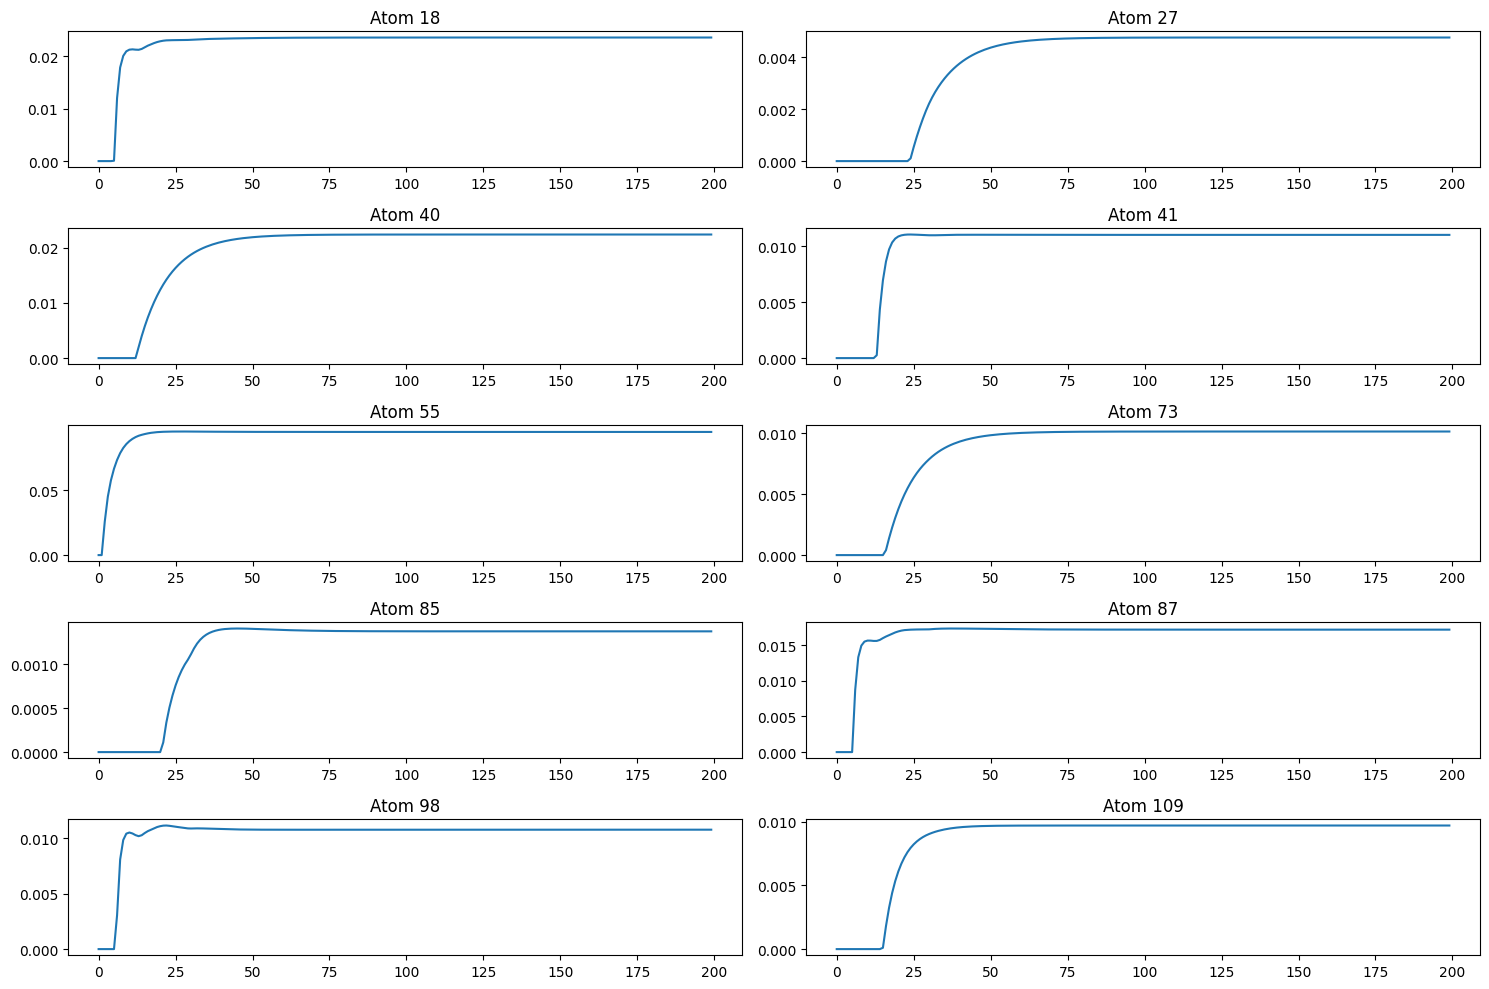

In [8]:
id_wv = 0
a_track = np.array(lca.a_track[0])
a_track_id = a_track[:, id_wv, :]
id_nonnull_atoms = np.where(a_track_id[-1] != 0)[0]
print(f"Number of non null atoms : {len(id_nonnull_atoms)}")
# plot the variation across iterations of 15 non null atoms
ncol = 2
nrow = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(15, 10), dpi=100, tight_layout=True)
for i in range(nrow):
    for j in range(ncol):
        ax[i, j].plot(a_track_id[:, id_nonnull_atoms[i * ncol + j]])
        ax[i, j].set_title(f"Atom {id_nonnull_atoms[i * ncol + j]}")
plt.show()

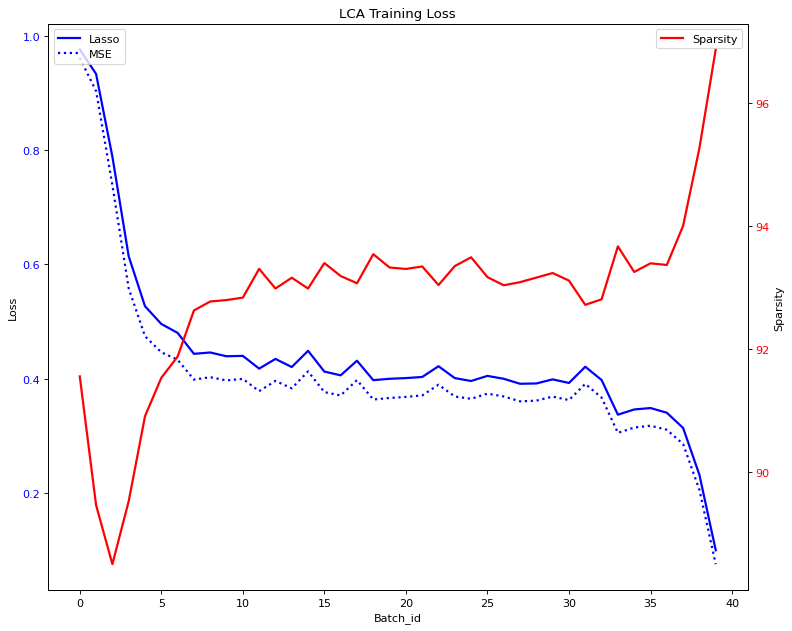

In [9]:
mse = np.zeros(len(mse_train))
sp = np.zeros(len(sp_train))
loss = np.zeros(len(lasso))
for i in range(len(mse)):
    mse[i] = mse_train[i]
    sp[i] = sp_train[i]
    loss[i] = lasso[i]
lca_lasso(mse, sp, loss, show=True)
# lca_atoms(infos, lca.D.cpu().numpy(), natoms=9, show=True)

In [27]:
# Eval
lca.mode = "eval"
lca.iters = 20
lca.q = 2**1 - 1
lca.a_track = []
lca.u_track = []
lca.v_track = []
lca.track_done = False
a_eval, mse_eval, sp_eval, lasso, t_sp = lca_iterates(lca, eval_loader, track=True)
l0_norm = np.mean(np.linalg.norm(a_eval, ord=0, axis=1))
print(f" l0-norm : {l0_norm} / sparsity : {np.mean(sp_eval[-1])}")
if n_model == "TDQ" or n_model == "LIF":
    print("mean temporal sparsity: %.2f" % (t_sp))

100%|██████████| 40/40 [00:04<00:00,  9.68it/s]

 l0-norm : 4.62162446975708 / sparsity : 98.21428680419922
mean temporal sparsity: 0.90


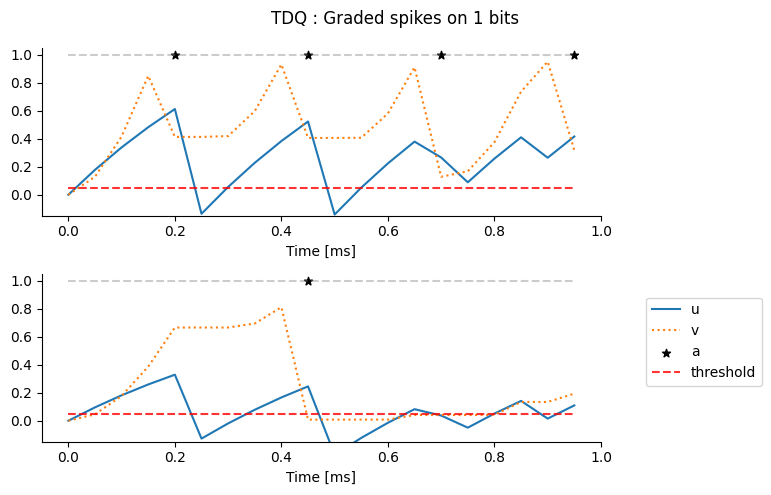

In [34]:
# get u_track, v_track and a_track and plot evolution along the 200 iterations=20ms
id_wv = 2
n_atoms = 11
a_track = np.vstack(lca.a_track)[:, id_wv, :]
u_track = np.vstack(lca.u_track)[:, id_wv, :]
v_track = np.vstack(lca.v_track)[:, id_wv, :] / lca.q
t = np.arange(0, lca.iters) * (1 / fs) * 1000
id_active_atoms = np.argsort(np.mean(a_track, axis=0))[::-1][:n_atoms]
# plot internal variables evolution
selected_id_atoms = [0, 3]
fig, axs = plt.subplots(2, 1, figsize=(8, 5), dpi=100, tight_layout=True)
fig.suptitle(f"TDQ : Graded spikes on {np.log2(lca.q+1):.0f} bits")
for i, id_na in enumerate(id_active_atoms[selected_id_atoms]):
    axs[i].plot(t, u_track[:, id_na], ls="-")
    axs[i].plot(t, v_track[:, id_na], ls=":")
    # scatter of a_track with stars for every values >0
    id_pos = np.where(a_track[:, id_na] > 0)[0]
    axs[i].scatter(t[id_pos], a_track[id_pos, id_na], marker="*", color="k")

    # axs[i].set_yscale("log")
    axs[i].set_ylim(-0.15, 1.05)
    axs[i].set_xlim(-1000 / fs, np.max(t) + 1000 / fs)
    axs[i].hlines(threshold, 0, np.max(t), color="r", ls="--", alpha=0.8)
    # axs[i].set_title(f"Atom {id_na}")
    # remove top and right spine
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].set_xlabel("Time [ms]")
    # plot grey semi-transparent horizontal line for every level of spike possible given 1/lca.q
    for j in range(1, lca.q + 1):
        axs[i].hlines(j / (lca.q), 0, np.max(t), color="grey", alpha=0.4, ls="--")


# axs[i].legend(["u", "v", "a", "threshold"])
# set legend on the side of the plot
axs[i].legend(["u", "v", "a", "threshold"], bbox_to_anchor=(1.3, 0.9))

plt.show()

In [ ]:
nneurons = infos["nneurons"]
gt_raster_eval = np.ones((2, dataset["eval"]["raster"].shape[0])) * -1
gt_raster_eval[0] = dataset["eval"]["raster"]
for ni in range(nneurons):
    idx_ni = np.where(dataset["eval"]["gt_raster"][1] == ni)[0]
    for i in idx_ni:
        # get the idx of the wvs which peaks_idx is the closest to dataset["eval"]["gt_raster"][0][i]
        idx = np.argmin(
            np.abs(dataset["eval"]["raster"] - dataset["eval"]["gt_raster"][0][i])
        )
        gt_raster_eval[1, i] = ni
gt_raster_eval = gt_raster_eval.astype(int)

In [ ]:
# gt_raster_eval = dataset["eval"]["raster"].numpy().T
fig, ax = plt.subplots(figsize=(10, 6), dpi=100, tight_layout=True)
presence_f = presence_factor(a_eval, gt_raster_eval, natoms)
sns.heatmap(
    presence_f,
    cmap="coolwarm",
    ax=ax,
)
# make the y tick labels rotate 0 degrees
plt.yticks(rotation=0)
plt.xticks(rotation=45)
ax.set_xlabel("Atom Index")
ax.set_ylabel("Neuron Index")
ax.set_title(f"Presence factor of LCA atoms for neurons")
plt.show()

In [ ]:
nneurons = 10
nwvs_per_neuron = 50
for ni in range(nneurons):
    idx_ni = np.where(gt_raster_eval[1] == ni)[0]
    wvs_ni = []
    j = 0
    fig, ax = plt.subplots(
        8, 4, figsize=(10, 10), sharex=True, sharey=True, tight_layout=True
    )
    ax = ax.flatten()
    for gti in idx_ni:
        # wvs_ni.append(wvs[gti])
        wv = dataset["eval"]["wv"][gti].numpy().reshape(32, -1)
        for k in range(32):
            ax[k].plot(wv[k])
        j += 1
        if j == nwvs_per_neuron:
            break
    plt.show()

In [ ]:
# # plot evolution of a and u for each neuron
# from matplotlib.lines import Line2D

# a_track = lca.a_track
# u_track = lca.u_track
# v_track = lca.v_track

# # neuron0
# a0 = a_track[0][:, 0, :].numpy().T
# u0 = u_track[0][:, 0, :].numpy().T
# v0 = v_track[0][:, 0, :].numpy().T
# # neuron1
# a1 = a_track[0][:, 1, :].numpy().T
# u1 = u_track[0][:, 1, :].numpy().T
# v1 = v_track[0][:, 1, :].numpy().T
# # get sns color palette for 4 atoms
# colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:4]
# # init a  2 grid specs for each neuron and 4 subplots per grid for each atoms
# # plot a and u per subplot and the threshold as a horizontal line
# fig = plt.figure(figsize=(12, 8), dpi=100, constrained_layout=True)
# gs = fig.add_gridspec(1, 2)
# # init a 2x2 subplots per grid
# ax0 = gs[0, 0].subgridspec(2, 2)
# ax1 = gs[0, 1].subgridspec(2, 2)
# # add title to each grid
# fig.suptitle(
#     "Evolution of the membrane potential and activation of LCA-neuron for waveforms of neuron 0 and 1",
#     fontsize=16,
# )
# dt = 1 / infos["fs"]
# t0 = 0
# tend = 800
# t = np.arange(t0, tend, 1) * dt * 1000
# for i in range(4):
#     # neuron 0
#     ax = fig.add_subplot(ax0[i])

#     if lca.n_model == "TDQ":
#         ax.plot(t, v0[i, t0:tend], color=colors[i], ls="-.", alpha=0.6)
#         for j, aq in enumerate(a0[i, t0:tend]):
#             if aq != 0:
#                 ax.vlines(t[j], 0, aq, color=colors[i], lw=0.7)
#     else:
#         ax.plot(t, a0[i, t0:tend], color=colors[i])
#     ax.plot(t, u0[i, t0:tend], color=colors[i], ls=":", lw=2)
#     ax.set_title(f"Atom {i}")
#     ax.axhline(threshold, color="k", linestyle="--")
#     if i == 0 or i == 2:
#         ax.set_ylabel("Amplitude [$\mu V$]")
#     if i == 2 or i == 3:
#         ax.set_xlabel("Time [ms]")
#     # remove top and right spines
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)

#     # neuron 1
#     ax = fig.add_subplot(ax1[i])
#     if lca.n_model == "TDQ":
#         ax.plot(t, v1[i, t0:tend], color=colors[i], ls="-.", alpha=0.6)
#         for j, aq in enumerate(a1[i, t0:tend]):
#             if aq != 0:
#                 ax.vlines(t[j], 0, aq, color=colors[i], lw=0.7)
#     else:
#         ax.plot(t, a1[i, t0:tend], color=colors[i])

#     ax.plot(t, u1[i, t0:tend], color=colors[i], ls=":", lw=2)
#     ax.set_title(f"Atom {i}")
#     ax.axhline(threshold, color="k", linestyle="--")
#     if i == 2 or i == 3:
#         ax.set_xlabel("Time [ms]")
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)

# # set legend outside of the plot for each type of line ':' = u, '-' = a, '--' = threshold and set the color to black for each
# custom_lines = [
#     Line2D([0], [0], color="k", ls="--"),
#     Line2D([0], [0], color="k", ls="-"),
#     Line2D([0], [0], color="k", ls=":"),
#     Line2D([0], [0], color="k", ls="-."),
# ]
# fig.legend(
#     custom_lines,
#     ["threshold", "a", "u", "Quantification Error"],
#     loc="upper right",
#     bbox_to_anchor=(0.99, 0.85),
# )
# plt.show()

Reconstruction

In [ ]:
# plot reconstruction
id_wv = 0
# get input and sparse approx of the input
wv = dataset["eval"]["wv"][id_wv].cpu().numpy()
D = lca.D.cpu().numpy()
a = a_eval[id_wv].reshape(1, -1)
recons = a @ D.T

# normalize both
wv = wv / np.linalg.norm(wv)
recons = recons / np.linalg.norm(recons)

# reshape for plotting
wv = wv.reshape(infos["nchan"], -1)
recons = recons.reshape(infos["nchan"], -1)

nrows = infos["nchan"] // 2
ncols = infos["nchan"] // nrows
fig, axes = plt.subplots(nrows, ncols, figsize=(5, 5), tight_layout=True)
axes = axes.flatten()
# cmap = plt.cm.get_cmap("tab10")
ymin = np.min([wv, recons])
ymax = np.max([wv, recons])
for i, ax in enumerate(axes):
    ax.plot(wv[i], color="b", alpha=0.5)
    ax.plot(recons[i], color="r", alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_title(f"Chan {i}")
plt.show()

## Clustering

In [ ]:
# # select k most active atoms for each sparse representations
# k_atoms = 48

# # train
# n_wvs_train = a_train.shape[0]
# idx_train = np.argsort(np.abs(a_train), axis=1)[:, -k_atoms:]
# a_train_m = np.zeros_like(a_train)
# a_train_m[np.arange(n_wvs_train)[:, None], idx_train] = a_train[
#     np.arange(n_wvs_train)[:, None], idx_train
# ]

# # eval
# n_wvs_eval = a_eval.shape[0]
# idx_eval = np.argsort(np.abs(a_eval), axis=1)[:, -k_atoms:]
# a_eval_m = np.zeros_like(a_eval)
# a_eval_m[np.arange(n_wvs_eval)[:, None], idx_eval] = a_eval[
#     np.arange(n_wvs_eval)[:, None], idx_eval
# ]

In [ ]:
# # plot sparse representations (a_eval) in the form of vertical heatmaps with grid lines in black and whites
# id_neuron = 0
# id_occ = 0
# id_wv = np.where(dataset["eval"]["raster"][:, 1] == id_neuron)[0][id_occ]
# print(f"Neuron {id_neuron}")
# # get gray color map and inverse it
# cmap = plt.cm.get_cmap("gray")
# cmap = cmap.reversed()
# fig, ax = plt.subplots(figsize=(1, 5), dpi=100, tight_layout=True)
# plt.imshow(
#     a_eval[id_wv].reshape(-1, 1),
#     cmap=cmap,
#     aspect="auto",
# )

# ax.set_xticks([])
# ax.set_yticks(np.arange(0, natoms + 1, 15))
# ax.set_yticklabels(np.arange(0, natoms + 1, 15), rotation=45)

# plt.show()

# #  plot input waveform
# # get 10 first color of the default color cycle
# colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# fig, ax = plt.subplots(figsize=(2, 4), dpi=100, tight_layout=True)
# mu.plot_mea_recording(
#     dataset["eval"]["wv"][id_wv].numpy().reshape(infos["nchan"], -1),
#     mea_probe,
#     ax=ax,
#     lw=2,
#     colors=colors[id_neuron],
#     alpha=0.8,
#     spacing=15,
#     scalebar=True,
#     time=30,
# )
# ax.set_title(f"Input waveform of neuron {id_neuron}")
# plt.show()

Apply k-Means - for drifting

In [ ]:
# clustering with kmeans with different number of clusters
n_clusters = [10, 15, 20, 30, 40, 50, 100]
ntrial = 5
acc_kmeans = np.zeros((len(n_clusters), ntrial))
for i, n_clust in enumerate(n_clusters):
    for t in range(ntrial):
        kmeans = KMeans(
            n_clusters=n_clust, random_state=5 * t, n_init="auto", init="random"
        ).fit(a_train)
        c_eval = kmeans.predict(a_eval)
        gt_raster_eval = dataset["eval"]["raster"].cpu().numpy().T
        st_eval = gt_raster_eval.astype(int)[0]
        pred_raster, snr_acc = compute_accuracy(
            infos, c_eval, st_eval, gt_raster_eval, match_mode="best"
        )
        acc_kmeans[i, t] = np.mean(snr_acc)
    print(f" mean accuracy for {n_clust} clusters : {np.mean(acc_kmeans[i])}")
# plot mean accuracy for each number of clusters with std error
fig, ax = plt.subplots(figsize=(8, 6), dpi=100, tight_layout=True)
ax.errorbar(n_clusters, np.mean(acc_kmeans, axis=1), yerr=np.std(acc_kmeans, axis=1))
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Mean accuracy")
ax.set_title("Mean accuracy for different number of clusters")
plt.show()

In [ ]:
n_clusters = 50
kmeans = KMeans(
    n_clusters=n_clusters, random_state=0, n_init="auto", init="random"
).fit(a_train)
# eval
c_eval = kmeans.predict(a_eval)
gt_raster_eval = dataset["eval"]["raster"].cpu().numpy().T
st_eval = gt_raster_eval.astype(int)[0]
if "boyden" in dataset_path:
    gt_eval = infos["gt_raster_eval"].reshape(1, -1)
    gt_raster_eval = np.concatenate((gt_eval, np.zeros((1, gt_eval.shape[1]))), axis=0)
pred_raster, snr_acc = compute_accuracy(
    infos, c_eval, st_eval, gt_raster_eval, match_mode="best"
)
# print("Mean spike sorting accuracy: %.2f" % (np.mean(snr_acc[:, 1])))
print("Mean spike sorting accuracy: %.2f" % (np.mean(snr_acc)))

In [ ]:
# plot sorting accuracy x = snr_acc[:, 0] and y = snr_acc[:, 1]
fig, ax = plt.subplots(figsize=(8, 5), dpi=100, tight_layout=True)
perm = np.argsort(infos["snr"])
ax.plot(infos["snr"][perm], snr_acc[perm])
ax.set_xlabel("SNR [dB]")
ax.set_ylabel("Accuracy")
plt.show()

Apply HDBSCAN

In [ ]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(a_train[a_train.shape[0] // 2 :])
c_eval = clusterer.fit_predict(a_eval)
print("computing spike sorting accuracy...")
gt_raster_eval = dataset["eval"]["raster"].cpu().numpy().T
st_eval = gt_raster_eval.astype(int)[0]
if "boyden" in dataset_path:
    gt_eval = infos["gt_raster_eval"].reshape(1, -1)
    gt_raster_eval = np.concatenate((gt_eval, np.zeros((1, gt_eval.shape[1]))), axis=0)
pred_raster, snr_acc = compute_accuracy(
    infos, c_eval, st_eval, gt_raster_eval, match_mode="best"
)
print("Mean spike sorting accuracy: %.2f" % (np.mean(snr_acc)))

CLustering with LCA

In [ ]:
# test on test set
test_loader = DataLoader(
    MEADataset(dataset["test"]["wv"], dataset["test"]["raster"], normalize=True),
    batch_size=batch_size,
    num_workers=4,
    pin_memory=False,
)
lca.mode = "eval"
lca.with_competition = True
a_test, mse_test, sp_test, lasso, _, _ = lca_iterates(lca, test_loader)
l0_norm = np.mean(np.linalg.norm(a_test, ord=0, axis=1))
print(f" l0-norm : {l0_norm} / sparsity : {np.mean(sp_test[-1])}")

In [ ]:
# evaluate lca2 on the output of lca for the test set
n_sample = 256 * 10
a_test_torch = torch.tensor(
    a_test[:n_sample], requires_grad=False, dtype=torch.float32, device="cpu"
)
# min-max scaling a_test_torch
a_test_torch = (a_test_torch - a_test_torch.min()) / (
    a_test_torch.max() - a_test_torch.min()
)
second_layer_test_loader = DataLoader(
    MEADataset(a_test_torch, dataset["test"]["raster"][:n_sample], normalize=False),
    batch_size=batch_size,
    num_workers=4,
    pin_memory=False,
)

In [ ]:
# second layer with LCA, learn pattern of actiation in the sparse codes of waveforms
natoms2 = 30
batch_size = 256
# create dataloader with a_eval
a_eval_torch = torch.tensor(
    a_eval, requires_grad=False, dtype=torch.float32, device="cpu"
)
# min-max scaling a_eval_torch
a_eval_torch = (a_eval_torch - a_eval_torch.min()) / (
    a_eval_torch.max() - a_eval_torch.min()
)
second_layer_loader = DataLoader(
    MEADataset(a_eval_torch, dataset["eval"]["raster"], normalize=False),
    batch_size=batch_size,
    num_workers=4,
    pin_memory=False,
)

In [ ]:
D2 = init.xavier_normal_(
    torch.zeros(
        (a_eval.shape[1], natoms2),
        requires_grad=False,
        dtype=torch.float32,
        device="cpu",
    )
)
lca2 = LCA(
    input_size=a_eval.shape[1],
    tau=0.02,
    threshold=0.08,
    natoms=natoms2,
    iters=400,
    lr=0.1,
    beta=0,
    n_model="V1",
    q=2**1 - 1,
    D=D2,
)
# learn second layer lca2
lca2.mode = "train"
lca2.with_competition = True
(
    a_train_cluster,
    mse_train_cluster,
    sp_train_cluster,
    lasso_train_cluster,
    _,
    _,
) = lca_iterates(lca2, second_layer_loader)

lca2.mode = "eval"
lca2.threshold = 0.2
lca2.n_model = "V1"
a_test_cluster, _, _, _, _, _ = lca_iterates(lca2, second_layer_test_loader)

In [ ]:
# visualize convergence of LCA-clustering
mse = np.zeros(len(mse_train_cluster))
sp = np.zeros(len(sp_train_cluster))
loss = np.zeros(len(lasso_train_cluster))
for i in range(len(mse)):
    mse[i] = mse_train_cluster[i][-1]
    sp[i] = sp_train_cluster[i][-1]
    loss[i] = lasso_train_cluster[i][-1]
lca_lasso(mse, sp, loss, show=True)

In [ ]:
# compute presence factor for lca2 on test set
gt_raster_eval = dataset["test"]["raster"][:n_sample].numpy().T
a_test = a_test_cluster[:n_sample]
id_neurons = np.unique(gt_raster_eval[1, :])
presence_f_lca2 = np.zeros((len(id_neurons), natoms2))
for i, id_ni in enumerate(id_neurons):
    idx_wvs_i = np.where(gt_raster_eval[1, :] == id_ni)[0]
    a_eval_i = a_test[idx_wvs_i, :]
    # print(f"Nb of waveforms for neuron {id_ni} : {len(idx_wvs_i)}")
    # compute percentage of activation of atoms for these neuron waveforms
    activation_rate = (np.sum(np.abs(a_eval_i) > 1e-4, axis=0) / len(a_eval_i)) * 100
    # compute mean value of the coeffs for these two classes
    mean_coeffs = np.zeros(natoms2)
    for j in range(natoms2):
        non_zero_idx0 = np.where(np.abs(a_eval_i[:, j]) > 1e-4)[0]
        if len(non_zero_idx0) > 0:
            mean_coeffs[j] = np.mean(np.abs(a_eval_i[non_zero_idx0, j]))
    presence_f_lca2[i, :] = activation_rate.reshape(1, -1) * mean_coeffs.reshape(1, -1)

In [ ]:
gt_raster_test = dataset["test"]["raster"][:n_sample].numpy().T
fig, ax = plt.subplots(figsize=(10, 6), dpi=100, tight_layout=True)
# presence_f_lca2 = presence_factor(infos["nneurons"], a_test_cluster, gt_raster_test, natoms2)
sns.heatmap(
    presence_f_lca2,
    cmap="coolwarm",
    ax=ax,
)
# make the y tick labels rotate 0 degrees
plt.yticks(rotation=0)
plt.xticks(rotation=45)
ax.set_xlabel("Atom Index")
ax.set_ylabel("Neuron Index")
# ax.set_title(f"Presence factor of LCA atoms for neurons")
plt.show()

In [ ]:
# set label of each wv to the argmax of the sparse representation
c_test = np.argmax(a_test_cluster, axis=1)
print("computing spike sorting accuracy...")
gt_raster_test = dataset["test"]["raster"][:n_sample].cpu().numpy().T
st_eval = gt_raster_test.astype(int)[0]
pred_raster, snr_acc = compute_accuracy(
    infos, c_test, st_eval, gt_raster_test, match_mode="best"
)
print("Mean spike sorting accuracy: %.2f" % (np.mean(snr_acc)))

In [ ]:
# plot sorting accuracy x = snr_acc[:, 0] and y = snr_acc[:, 1]
fig, ax = plt.subplots(figsize=(8, 5), dpi=100, tight_layout=True)
perm = infos["snr"].argsort()
snr = infos["snr"][perm]
snr_acc = snr_acc[perm]
ax.plot(snr, snr_acc)
ax.set_xlabel("SNR [dB]")
ax.set_ylabel("Accuracy")
plt.show()

In [ ]:
# display atoms of lca2
dico_lca2 = lca2.D.numpy().T
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
# plt dico_lca2 as image with delimitors for each rows
ax.imshow(
    dico_lca2, cmap="gray", vmin=0, vmax=1, aspect="auto", interpolation="nearest"
)
ax.set_title("Dictionary of LCA2-Clustering")
ax.set_xlabel("Sparse Code space")
ax.set_ylabel("Second Layer Atoms")
fig.tight_layout()
plt.show()

Section for drifting recording only 

In [ ]:
# save learned dictionary
D = lca.D.cpu().numpy()

In [ ]:
# load drifting templates
dataset_drift_path = "data/SYMEA_n12_nsd5_Npxl24_during_drift.h5"
infos_drift, waveforms_drift = load_symea(dataset_drift_path)
infos_drift["fs"] = 1e4
infos_drift["input_size"] = waveforms_drift.shape[1]
gt_raster_drift = infos_drift["gt_raster"]  # raster = spike timings + neuron id

# build dataloader
normalize = True
input_dim = waveforms_drift.shape[1]
drift_loader = DataLoader(
    MEADataset(
        torch.tensor(waveforms_drift),
        torch.tensor(gt_raster_drift.T),
        normalize=normalize,
    ),
    batch_size=64,
    num_workers=4,
    pin_memory=False,
)

In [ ]:
# inference on drifting waveforms
lca2.mode = "train"
lca2.lr = 0.01
# lca.q = 2**1 - 1
lca2.with_competition = True
lca2.D = torch.tensor(
    D_clustering, requires_grad=False, dtype=torch.float32, device="cpu"
)
a_drift, _, _, _, _, _ = lca_iterates(lca2, drift_loader)
l0_norm = np.mean(np.linalg.norm(a_drift, ord=0, axis=1))
print(f"mean l0-norm : {l0_norm}")

Load k-SVD dict and do the same with it

In [ ]:
# plot acuracy vs drift_um
# slice a_eval
accuracies = np.zeros(infos_drift["drift_timings"].shape[0])
for step in range(infos_drift["drift_timings"].shape[0]):
    # find all indices in peak_idx that are in the range of drift_timings
    idx = np.where(
        (infos_drift["peak_idx"] >= infos_drift["drift_timings"][step, 0] * fs)
        & (infos_drift["peak_idx"] <= infos_drift["drift_timings"][step, 1] * fs)
    )[0]
    # slice a_drift
    a_drift_slice = a_drift[idx, :]
    gt_raster_drift_slice = gt_raster_drift[:, idx]
    st_eval_slice = gt_raster_drift_slice[0, :].astype(int)

    # compute accuracy
    # c_eval_slice = kmeans.predict(a_drift_slice)
    c_eval_slice = np.argmax(a_drift_slice, axis=1)
    # c_eval_slice = clusterer.fit_predict(a_drift_slice)
    pred_raster, snr_acc_slice = compute_accuracy(
        infos_drift,
        c_eval_slice,
        st_eval_slice,
        gt_raster_drift_slice,
        match_mode="best",
    )
    accuracies[step] = np.mean(snr_acc_slice[:, 1])
    # print("Mean spike sorting accuracy: %.2f" % (np.mean(snr_acc_slice[:, 1])))
# load ksvd accuracies
# with h5.File(
#     "logs/saved_dict_coeffs_h5/ksvd_natom320_k9_iter200_drift_accuracies.h5", "r"
# ) as f:
#     accuracies_ksvd = f["accuracies"][:]
# f.close()

In [ ]:
# plot accuracy vs drift_um
plt.plot(infos_drift["drift_um"], accuracies, label="LCA")
# plt.plot(infos_drift["drift_um"], accuracies_ksvd, label="K-SVD")
plt.legend()
plt.title("Accuracy vs drift of neuron")
plt.xlabel("Drift of neuron from initial position [$\mu m$]")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
max_active_atoms = 16
accuracies = np.zeros(max_active_atoms)
for k_atoms in range(1, max_active_atoms + 1):
    # train
    n_wvs_train = a_train.shape[0]
    idx_train = np.argsort(np.abs(a_train), axis=1)[:, -k_atoms:]
    a_train_m = np.zeros_like(a_train)
    a_train_m[np.arange(n_wvs_train)[:, None], idx_train] = a_train[
        np.arange(n_wvs_train)[:, None], idx_train
    ]

    # eval
    n_wvs_eval = a_eval.shape[0]
    idx_eval = np.argsort(np.abs(a_eval), axis=1)[:, -k_atoms:]
    a_eval_m = np.zeros_like(a_eval)
    a_eval_m[np.arange(n_wvs_eval)[:, None], idx_eval] = a_eval[
        np.arange(n_wvs_eval)[:, None], idx_eval
    ]

    clusterer = hdbscan.HDBSCAN(
        core_dist_n_jobs=6,
    )
    clusterer.fit(a_train_m)
    c_eval = clusterer.fit_predict(a_eval_m)
    print("computing spike sorting accuracy...")
    gt_raster_eval = dataset["eval"]["raster"].cpu().numpy().T
    st_eval = gt_raster_eval.astype(int)[0]
    if "boyden" in dataset_path:
        gt_eval = infos["gt_raster_eval"].reshape(1, -1)
        gt_raster_eval = np.concatenate(
            (gt_eval, np.zeros((1, gt_eval.shape[1]))), axis=0
        )
    pred_raster, snr_acc = compute_accuracy(
        infos, c_eval, st_eval, gt_raster_eval, match_mode="best"
    )
    accuracies[k_atoms - 1] = np.mean(snr_acc[:, 1])
    print(f"k_atoms: {k_atoms} / accuracy: {accuracies[k_atoms-1]}")
    # print("Mean spike sorting accuracy: %.2f" % (np.mean(snr_acc[:, 1])))
    # print('Loss: %.2f' %(loss))

In [ ]:
# # compute silhouette_score for lca_a_eval
# lca_silhouette = silhouette_score(a_eval, gt_raster_eval[1], random_state=0)
# raw_silhouette = silhouette_score(
#     dataset["eval"]["wv"].cpu().numpy(), gt_raster_eval[1], random_state=0
# )
# print("lca silhouette score: ", lca_silhouette)
# print("raw silhouette score: ", raw_silhouette)

# # compute calinski_harabasz_score for lca_a_eval and ksvd_a_eval
# lca_calinski = calinski_harabasz_score(a_eval, gt_raster_eval[1])
# raw_calinski = calinski_harabasz_score(
#     dataset["eval"]["wv"].cpu().numpy(), gt_raster_eval[1]
# )
# print("lca calinski score: ", lca_calinski)
# print("raw calinski score: ", raw_calinski)

# # compute davies_bouldin_score for lca_a_eval and ksvd_a_eval
# lca_davies = davies_bouldin_score(a_eval, gt_raster_eval[1])
# raw_davies = davies_bouldin_score(
#     dataset["eval"]["wv"].cpu().numpy(), gt_raster_eval[1]
# )
# print("lca davies score: ", lca_davies)
# print("raw davies score: ", raw_davies)

Save results

In [ ]:
params = f"natoms = {natoms} / iters = {iters} / lr = {lr} / beta = {beta} / tau = {tau} / threshold = {threshold} / q = {q} / n_model = {n_model}"
with h5.File(
    "logs/saved_dict_coeffs_h5/lca_n48_nsd10_Npxl24_SYMEA_1500_0.h5", "w"
) as f:
    f.create_dataset("dict", data=lca.D.cpu().numpy())
    f.create_dataset("a_train", data=a_train)
    f.create_dataset("a_eval", data=a_eval)
    f.create_dataset("gt_raster_train", data=dataset["train"]["raster"].numpy().T)
    f.create_dataset("gt_raster_eval", data=gt_raster_eval)
    f.create_dataset("params", data=params)
    # f.create_dataset("accuracies", data=accuracies)
    # f.create_dataset("snr_acc", data=np.array(snr_acc, dtype=np.float32))
f.close()

In [ ]:
# # VisualIzation of dictionary learning
# # plot reccurent weights adjacency matrix
# D = lca.D.cpu().numpy()
# Wr = D.T @ D - np.eye(D.shape[1])
# plt.imshow(Wr, cmap="gray")
# plt.colorbar()
# plt.show()

# # plot histogram of values from Wr
# plt.hist(-Wr.flatten(), bins=1000, density=True)
# plt.vlines(0, 0, 10, color="r", ls="-", lw=1, alpha=0.5)
# plt.show()

Plot spike sorting results

In [ ]:
# plot
raster_eval = dataset["eval"]["raster"].cpu().numpy().T
lca_sorting(infos, raster_eval, snr_acc, lca.D.cpu().numpy(), pred_raster, show=True)